### Import Packages

In [33]:
import pandas as pd
import numpy as np
from scipy import stats

# clustering algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from pathlib import Path
from tqdm import tqdm
import importlib
import module
try:
    importlib.reload(module) # reload module
except NameError:
    pass

### Import Data

In [2]:
path= Path('data/clean/clean_data.parquet')
cols = list(pd.read_parquet(path))
print(cols)

['id', 'age', 'education', 'marital_status', 'income', 'is_parent', 'kidhome', 'teenhome', 'dt_customer', 'dt_customer_day', 'dt_customer_dow', 'dt_customer_wom', 'dt_customer_month', 'dt_customer_year', 'recency', 'mnt_wines', 'mnt_fruits', 'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products', 'mnt_gold_prods', 'total_spent', 'num_web_purchases', 'num_catalog_purchases', 'num_store_purchases', 'total_purchase', 'num_web_visits_month', 'accepted_cmp1', 'accepted_cmp2', 'accepted_cmp3', 'accepted_cmp4', 'accepted_cmp5', 'accepted_cmp6', 'num_deals_purchases', 'complain']


We will not read unused columns.

In [3]:
df= pd.read_parquet(path= path, columns= [col for col in cols if col not in[
    'id', 'dt_customer', 'dt_customer_day', 'dt_customer_dow', 'dt_customer_wom', 'dt_customer_month', 'dt_customer_year'
]])

### Hopkins Test

Now we we will use Hopkins Test to check if the data contains meaningful clusters.

In [4]:
columns= ['age', 'income', 'total_spent', 'total_purchase']
scaler= StandardScaler()

data= pd.DataFrame(df
    .pipe(module.drop_outliers, columns, 'z_score')
    .pipe(pd.get_dummies)
    .pipe(scaler.fit_transform)
)
module.hopkins_test(data)

Hopkins statistic=  0.883: there are meaningful clusters


### Select Algorithm and Number of Cluster

In [35]:
clusters= range(2, 6, 1)

models= []
n_clusters= []
silhouette_scores= []

def append_scores(model, i):
    n_clusters.append(i)
    models.append(type(model).__name__)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

for i in tqdm(clusters):
    
    columns= ['age', 'income', 'total_spent', 'total_purchase']
    scaler= StandardScaler()
    X= (df
        .pipe(module.drop_outliers, columns, 'z_score') # drop outliers in selected columns
        .pipe(pd.get_dummies)
        .pipe(scaler.fit_transform)
    )

    # k-means
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        kmeans= KMeans(n_clusters= i, random_state= 8, init= 'k-means++', n_init= 10)
        cluster_labels= kmeans.fit_predict(X)
        append_scores(kmeans, i)

    # agglomerative clustering
    agglo= AgglomerativeClustering(n_clusters= i)
    cluster_labels= agglo.fit_predict(X)
    append_scores(agglo, i)

    # note: spectral clustering is very slow in this case
    # spectral= SpectralClustering(n_clusters= i, random_state= 8)
    # cluster_labels= spectral.fit_predict(X)
    # append_scores(spectral, i)

results= pd.DataFrame(data= {
    'model': models, 
    'n_clusters': n_clusters, 
    'silhouette_score': silhouette_scores
}).sort_values('silhouette_score', ignore_index= True)
results

100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


,model,n_clusters,silhouette_score
0,AgglomerativeClustering,3,0.222737
1,KMeans,3,0.223923
2,AgglomerativeClustering,2,0.225513
3,KMeans,2,0.237778
4,AgglomerativeClustering,5,0.240888
5,AgglomerativeClustering,4,0.243884
6,KMeans,4,0.246326
7,KMeans,5,0.247528


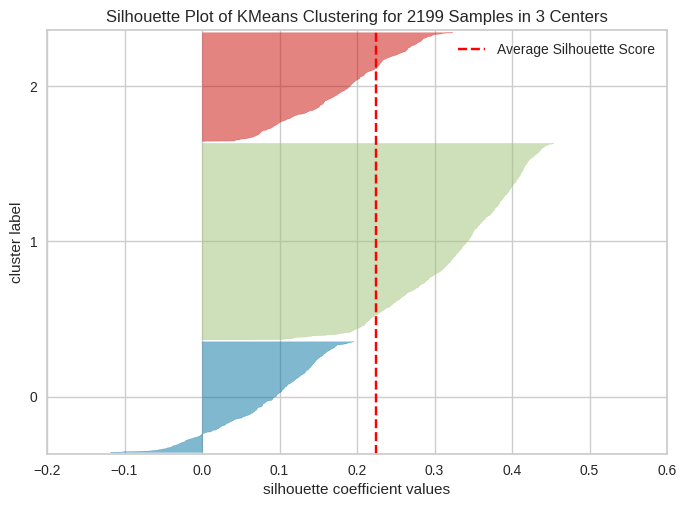

AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'

In [37]:
X= (df
    .pipe(module.drop_outliers, columns, 'z_score')
    .pipe(pd.get_dummies)
    .pipe(scaler.fit_transform)
)

with warnings.catch_warnings():
    warnings.simplefilter('ignore', category= UserWarning)
    model = KMeans(3, random_state= 8, init= 'random', n_init= 'auto')
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(X)
    visualizer.show()
    plt.show()

model = AgglomerativeClustering(3)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X)
visualizer.show()
plt.show()

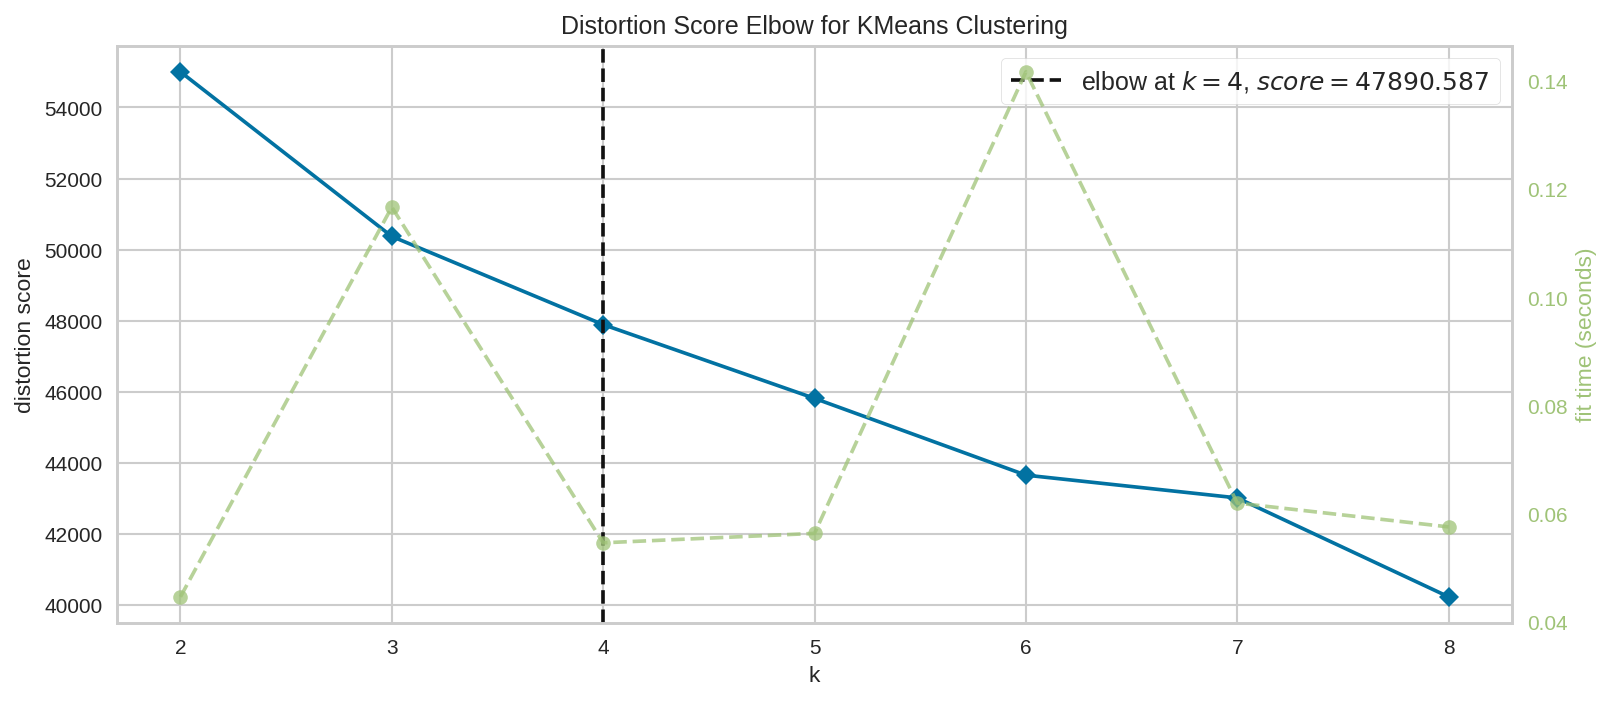

In [7]:
fig, ax= plt.subplots(figsize= (12, 5), dpi= 150)
fig.patch.set_facecolor('white')

model = KMeans(init= 'random', n_init= 'auto')
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category= UserWarning)
    visualizer = KElbowVisualizer(model, k=(2, 9), metric= 'distortion', ax= ax)
    visualizer.fit(X)      
    visualizer.show()

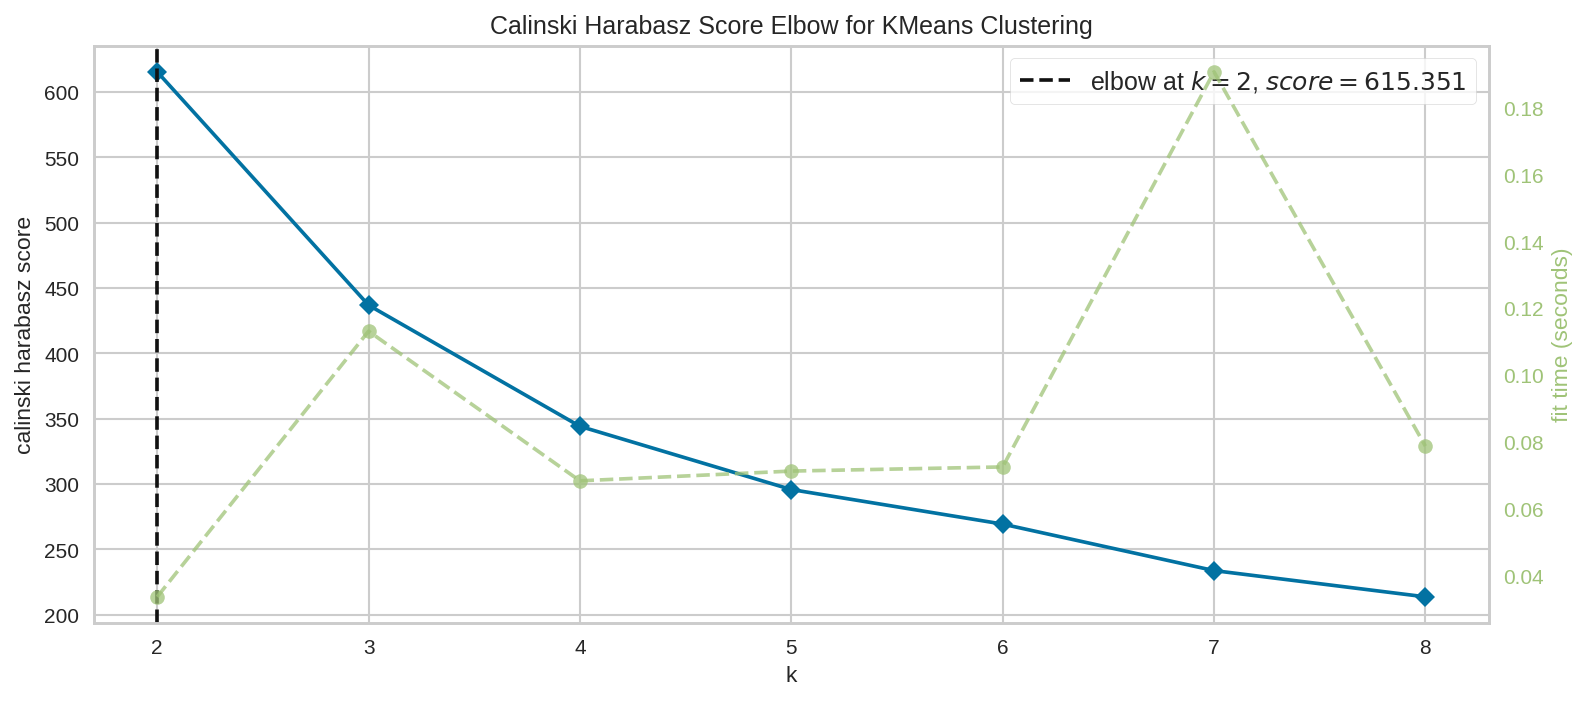

In [8]:
fig, ax= plt.subplots(figsize= (12, 5), dpi= 150)
fig.patch.set_facecolor('white')

model = KMeans(init= 'random', n_init= 'auto')
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category= UserWarning)
    visualizer = KElbowVisualizer(model, k=(2, 9), metric= 'calinski_harabasz', ax= ax)
    visualizer.fit(X)      
    visualizer.show()

Based on numerous metrics above, I decided to select 5 clusters. Some consideration for this:
1. KMeans are easily interpretable
2. Silhouette of KMeans with 5 clusters are separated nicely
3. Selecting too many clusters is not practical in real world application

### Segment Customers

Here, we will segment customers and directly assign them to our df.

In [9]:
kmeans= KMeans(n_clusters= 5, init='random', n_init= 'auto', random_state= 8)
scaler= StandardScaler()

with warnings.catch_warnings():
    warnings.simplefilter('ignore', category= UserWarning)
    df= (df
        .pipe(module.drop_outliers, columns, 'z_score')
        .assign(
            segment= lambda df_: kmeans.fit_predict(
                df_.pipe(pd.get_dummies).pipe(scaler.fit_transform)
            )
        )
        # make segment categorical so that it is automatically sorted
        .assign(segment= lambda df_: df_['segment']
            .astype(pd.CategoricalDtype([0, 1, 2, 3, 4], ordered= True))
        )
    )

### Segment Profiling

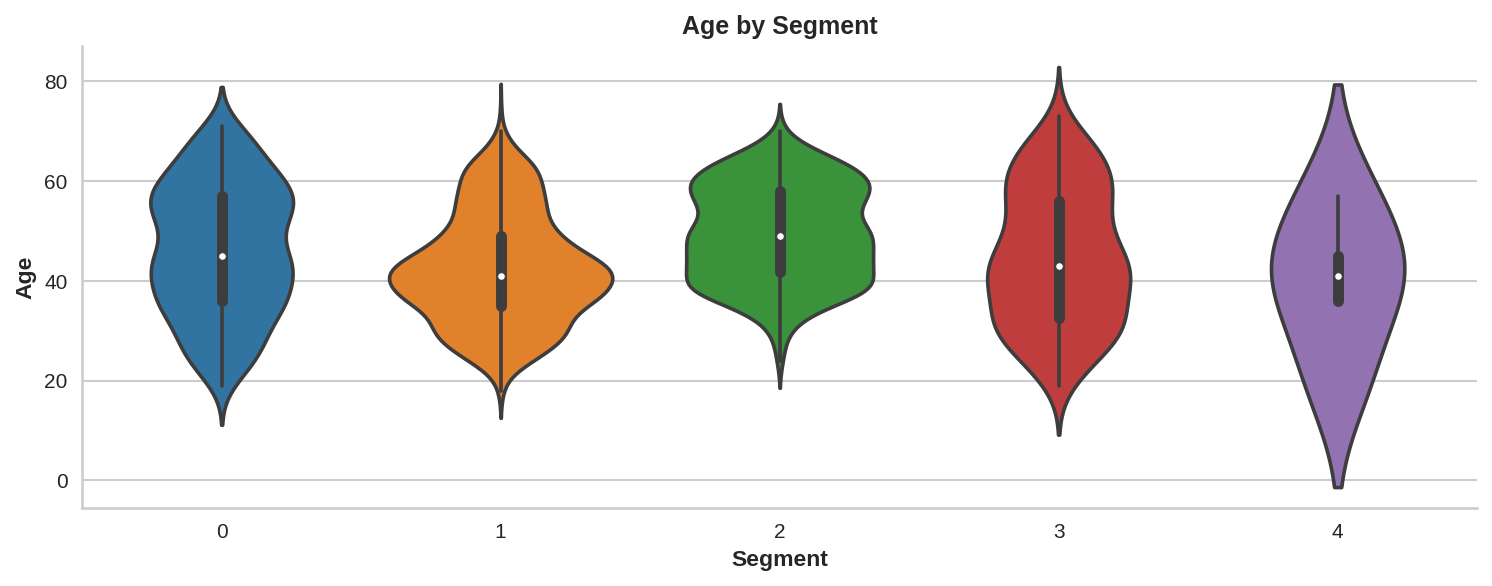

In [10]:
module.plot_violin(
    x= 'segment',
    y= 'age',
    df= df
)

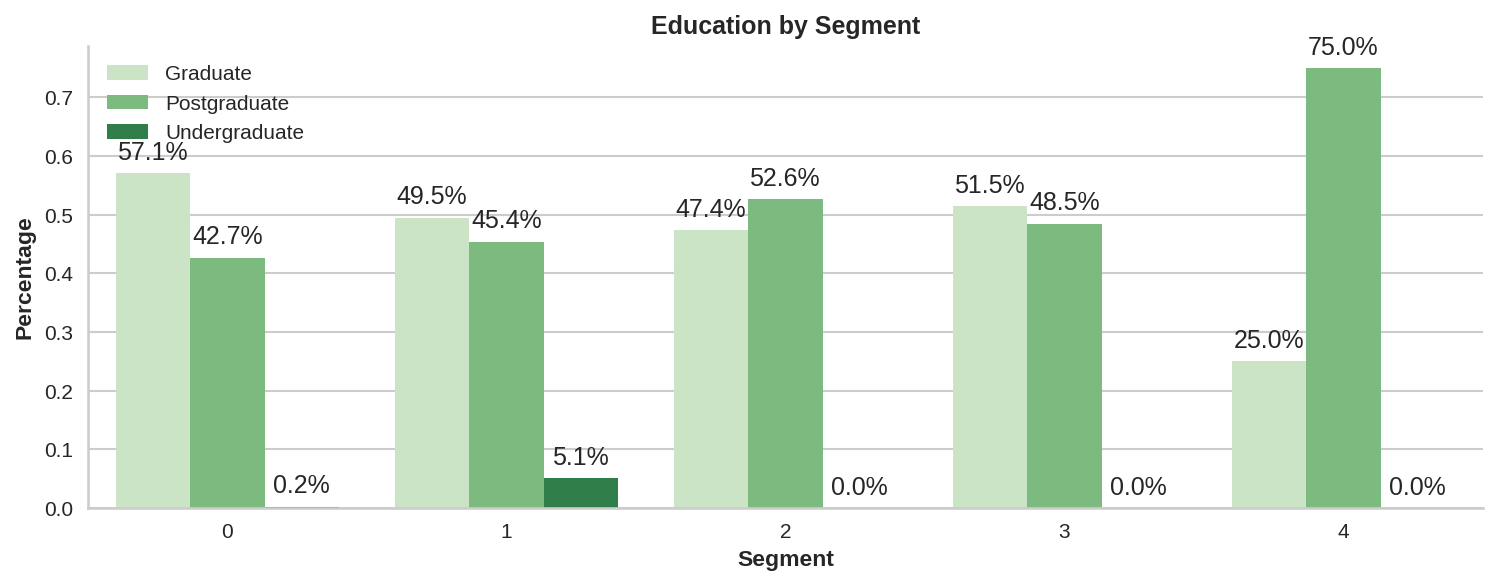

In [11]:
module.plot_bar_with_hue(
    hue= 'education', 
    df= df
)

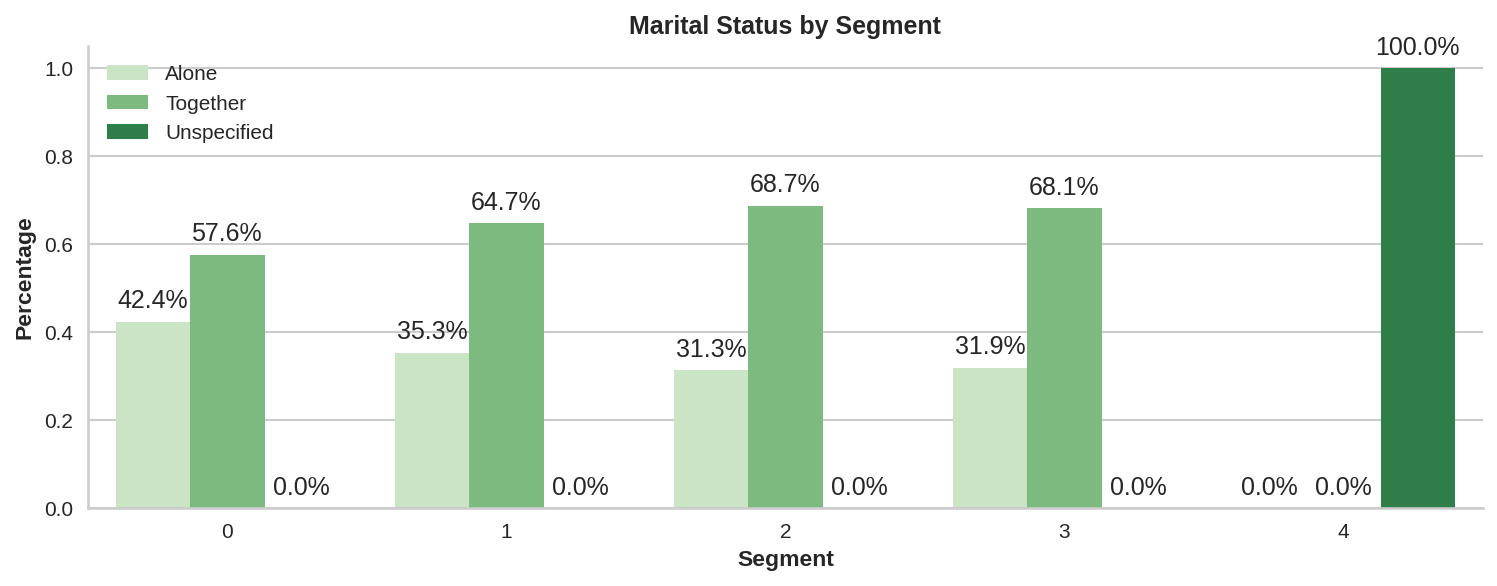

In [12]:
module.plot_bar_with_hue(
    hue= 'marital_status', 
    df= df
)

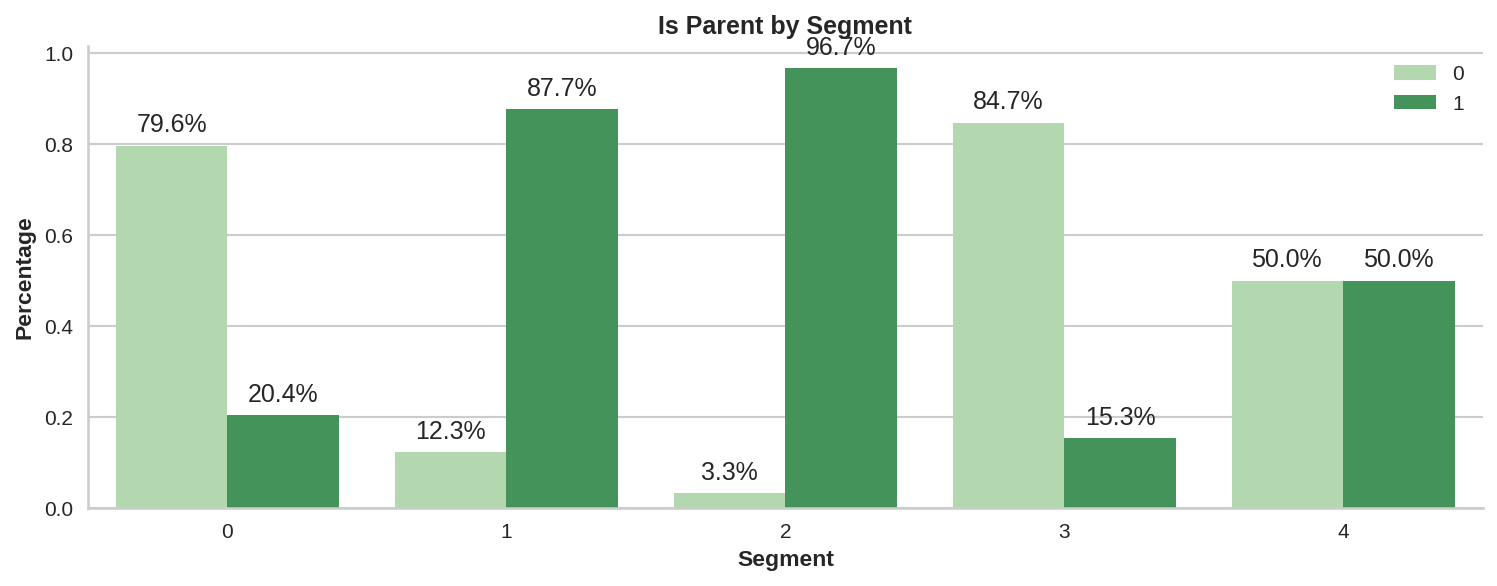

In [13]:
module.plot_bar_with_hue(
    hue= 'is_parent', 
    df= df
)

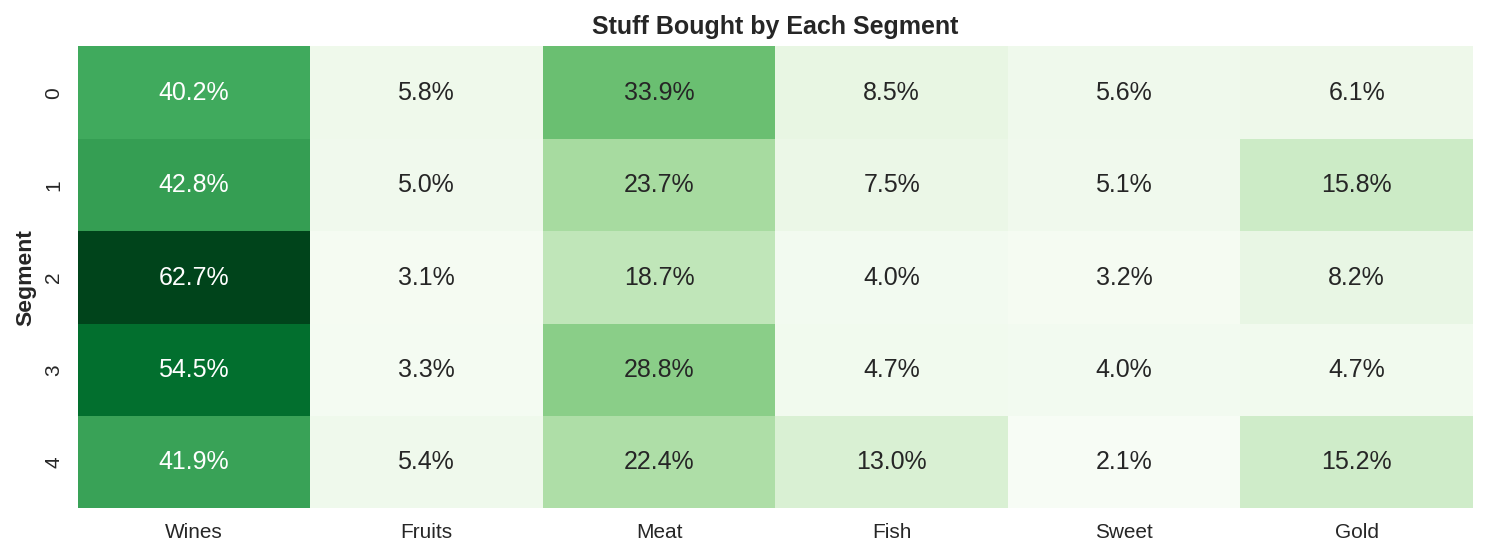

In [14]:
y= 'segment'

data= (df
    .loc[:, df.columns.str.contains('mnt|segment', regex= True)]
    .groupby(y)
    .mean()
    .apply(lambda x: (x/x.sum()), axis= 'columns')
)

module.plot_heatmap(data, 'Stuff Bought by Each Segment')

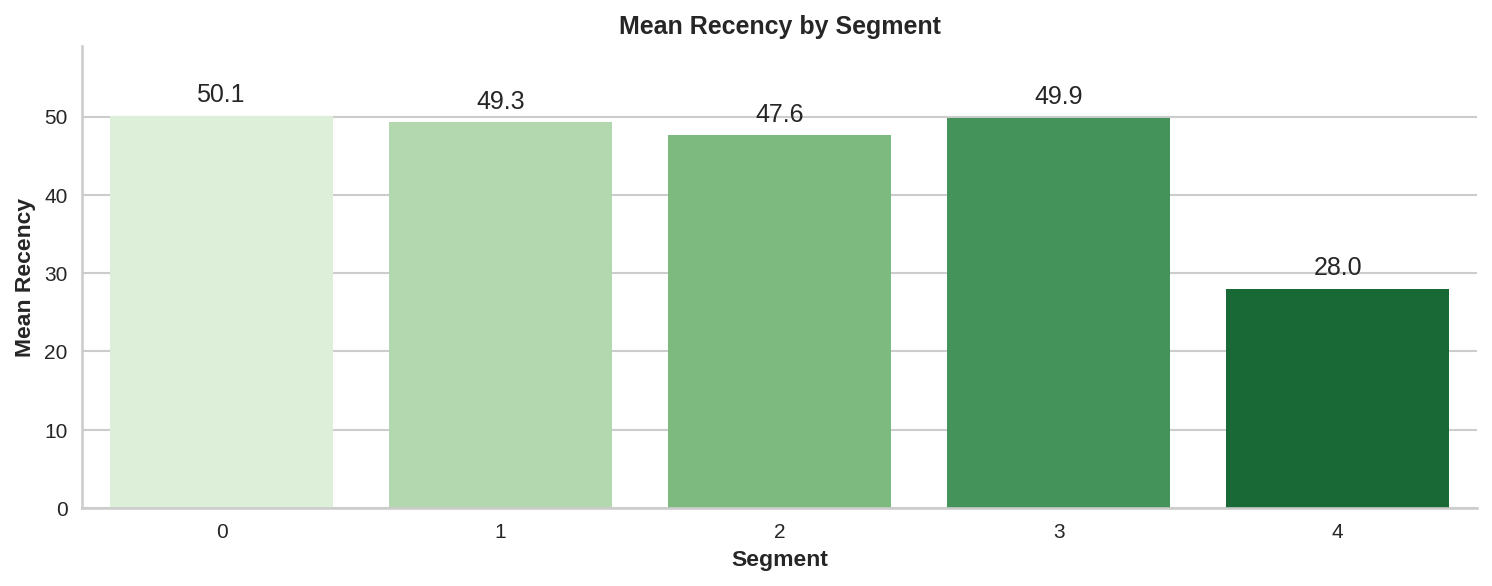

In [15]:
data= (df
    .groupby('segment')
    .agg(mean_recency= ('recency', 'mean'))
    .reset_index()
)
module.plot_bar(
    x= 'segment', 
    y= 'mean_recency', 
    df= data, 
    ylim= (0, 59)
)

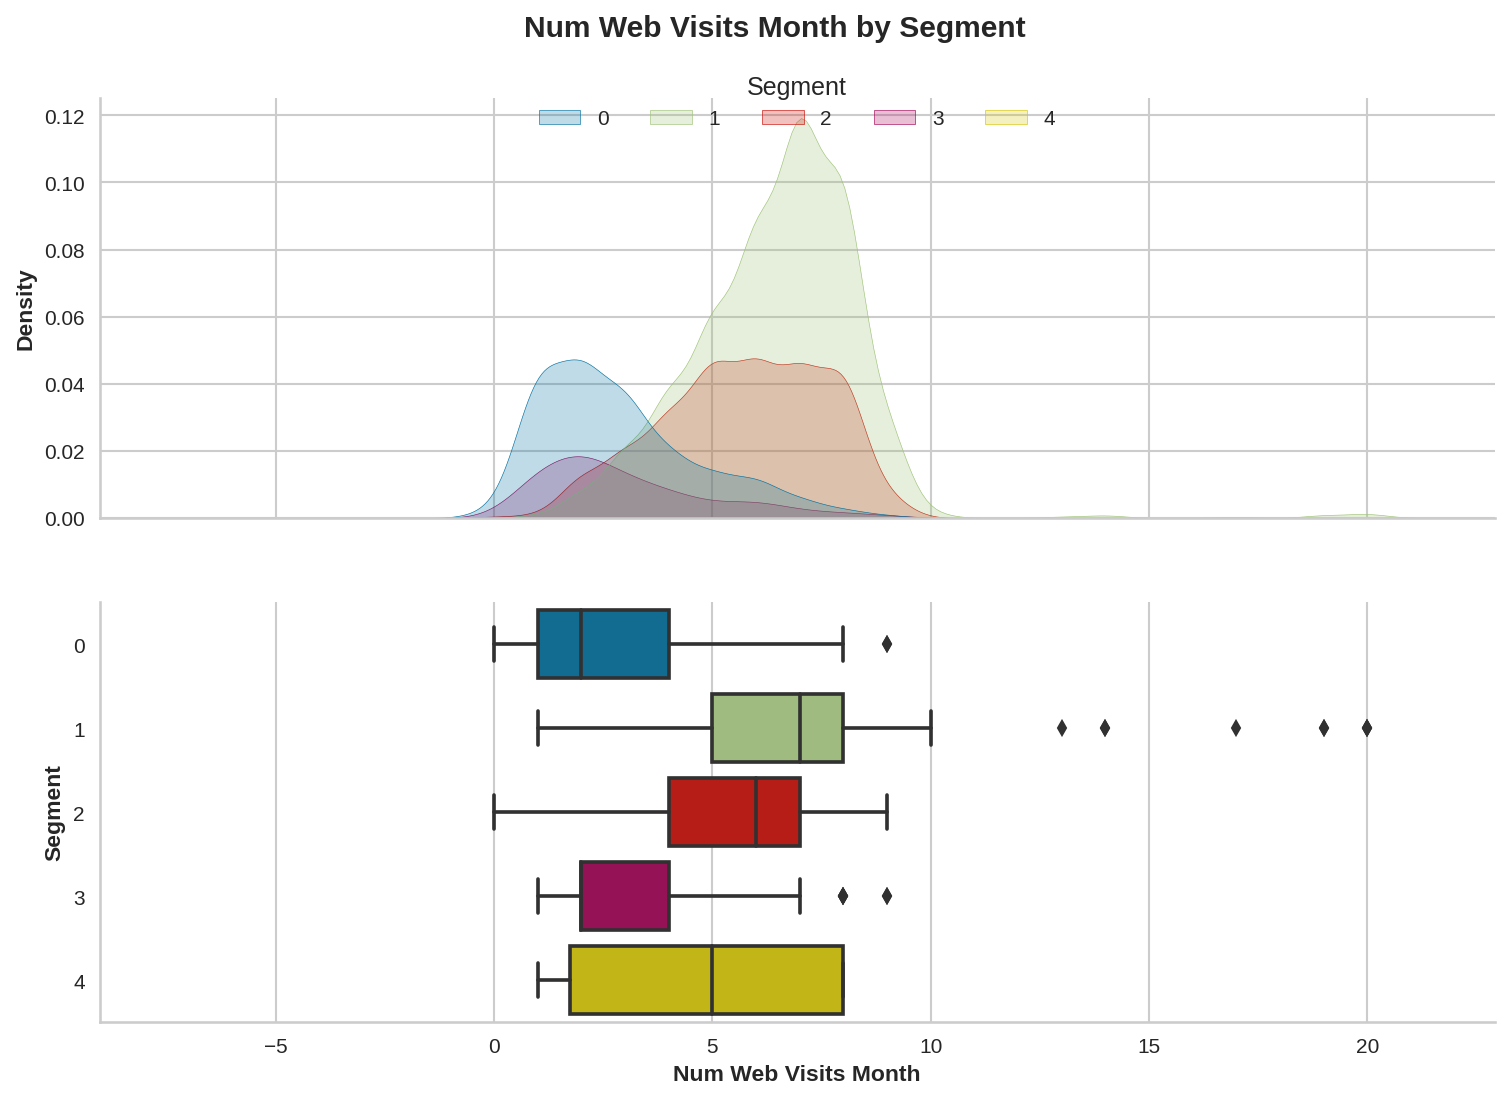

In [16]:
module.plot_kde_box(y= 'segment', x= 'num_web_visits_month', df= df)

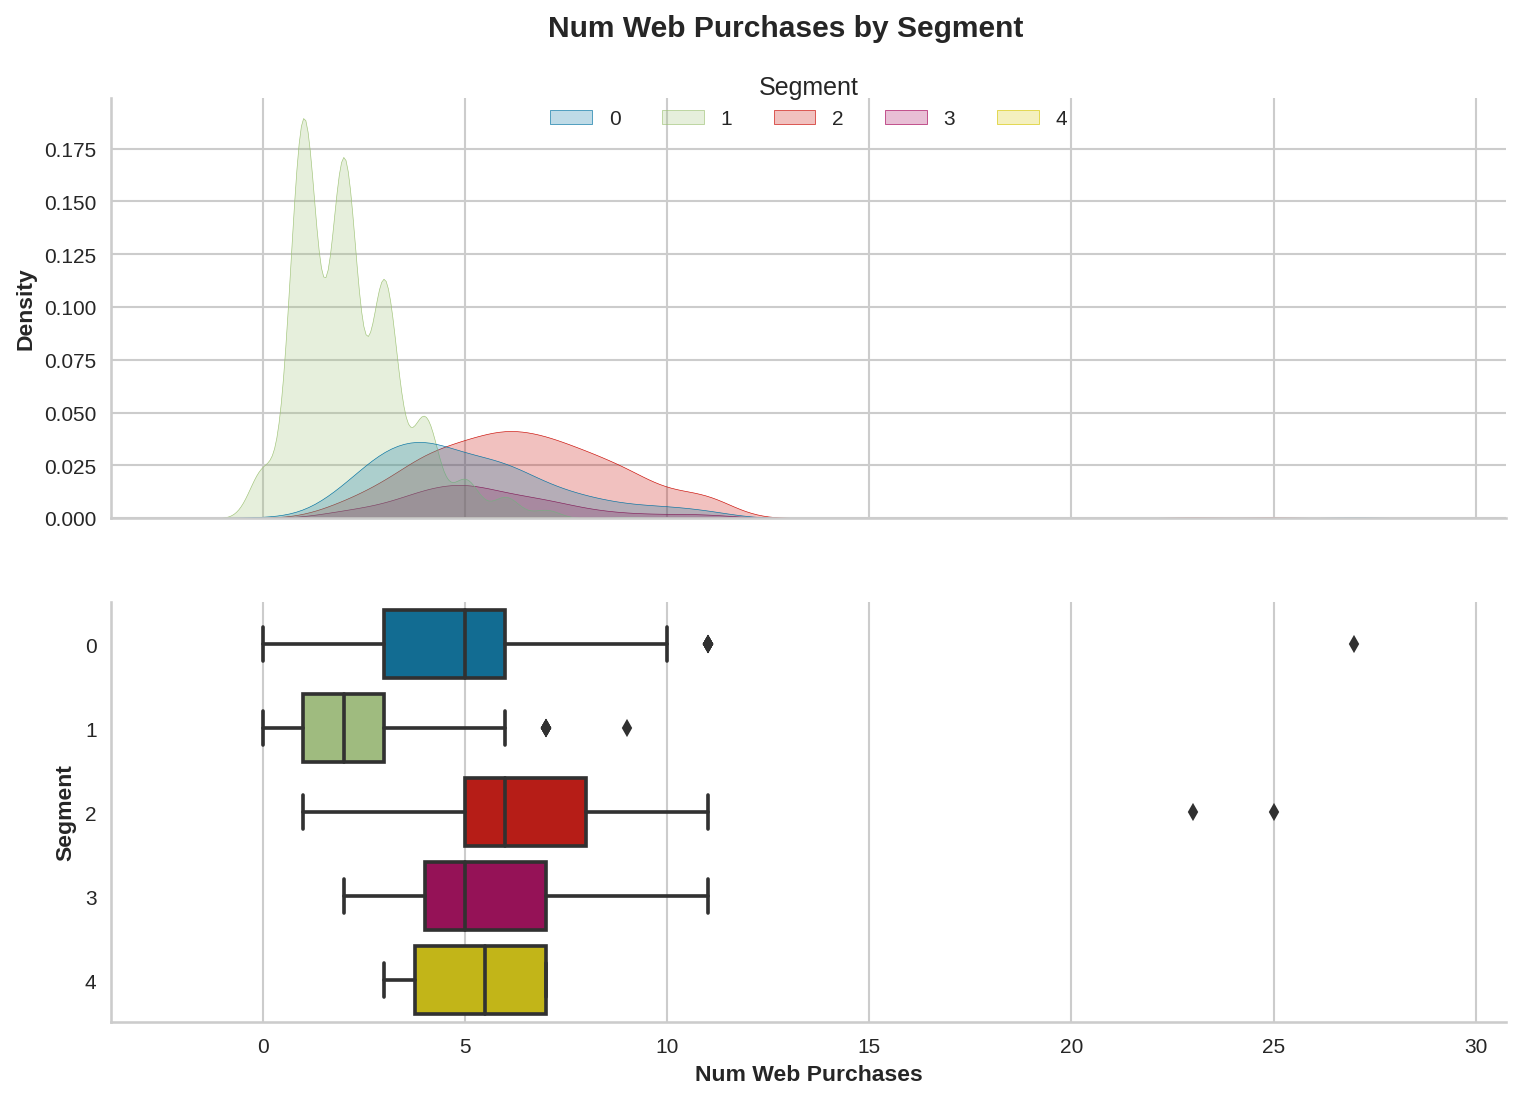

In [17]:
module.plot_kde_box(y= 'segment', x= 'num_web_purchases', df= df)

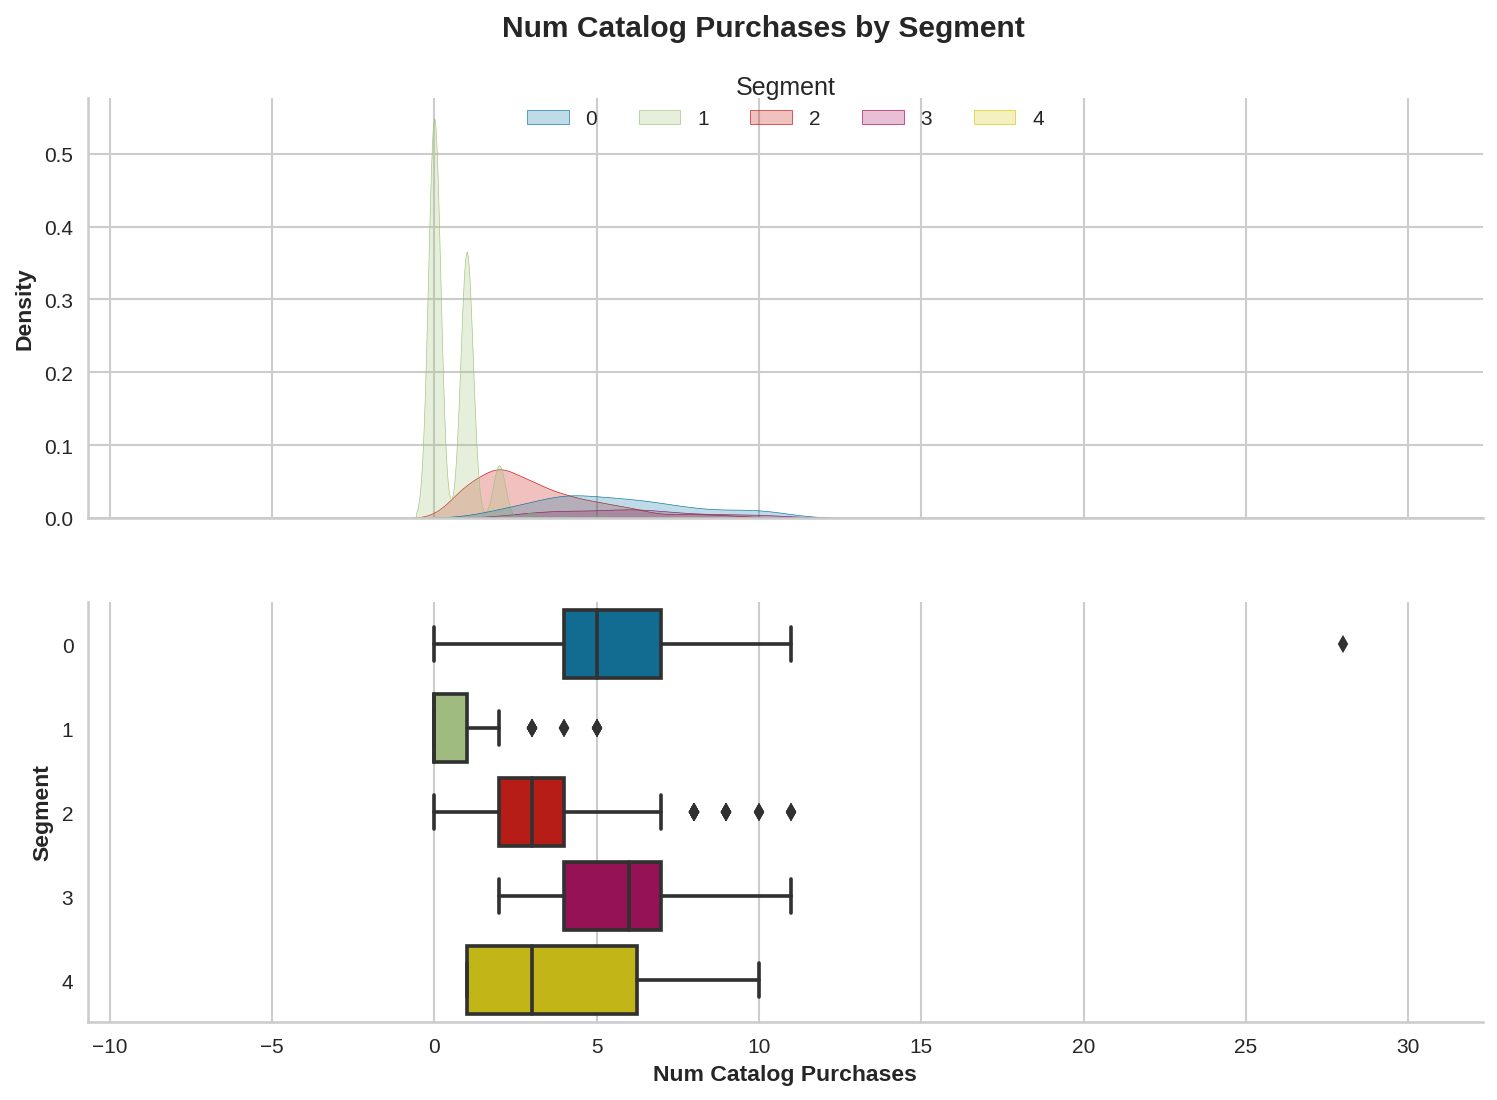

In [18]:
module.plot_kde_box(y= 'segment', x= 'num_catalog_purchases', df= df)

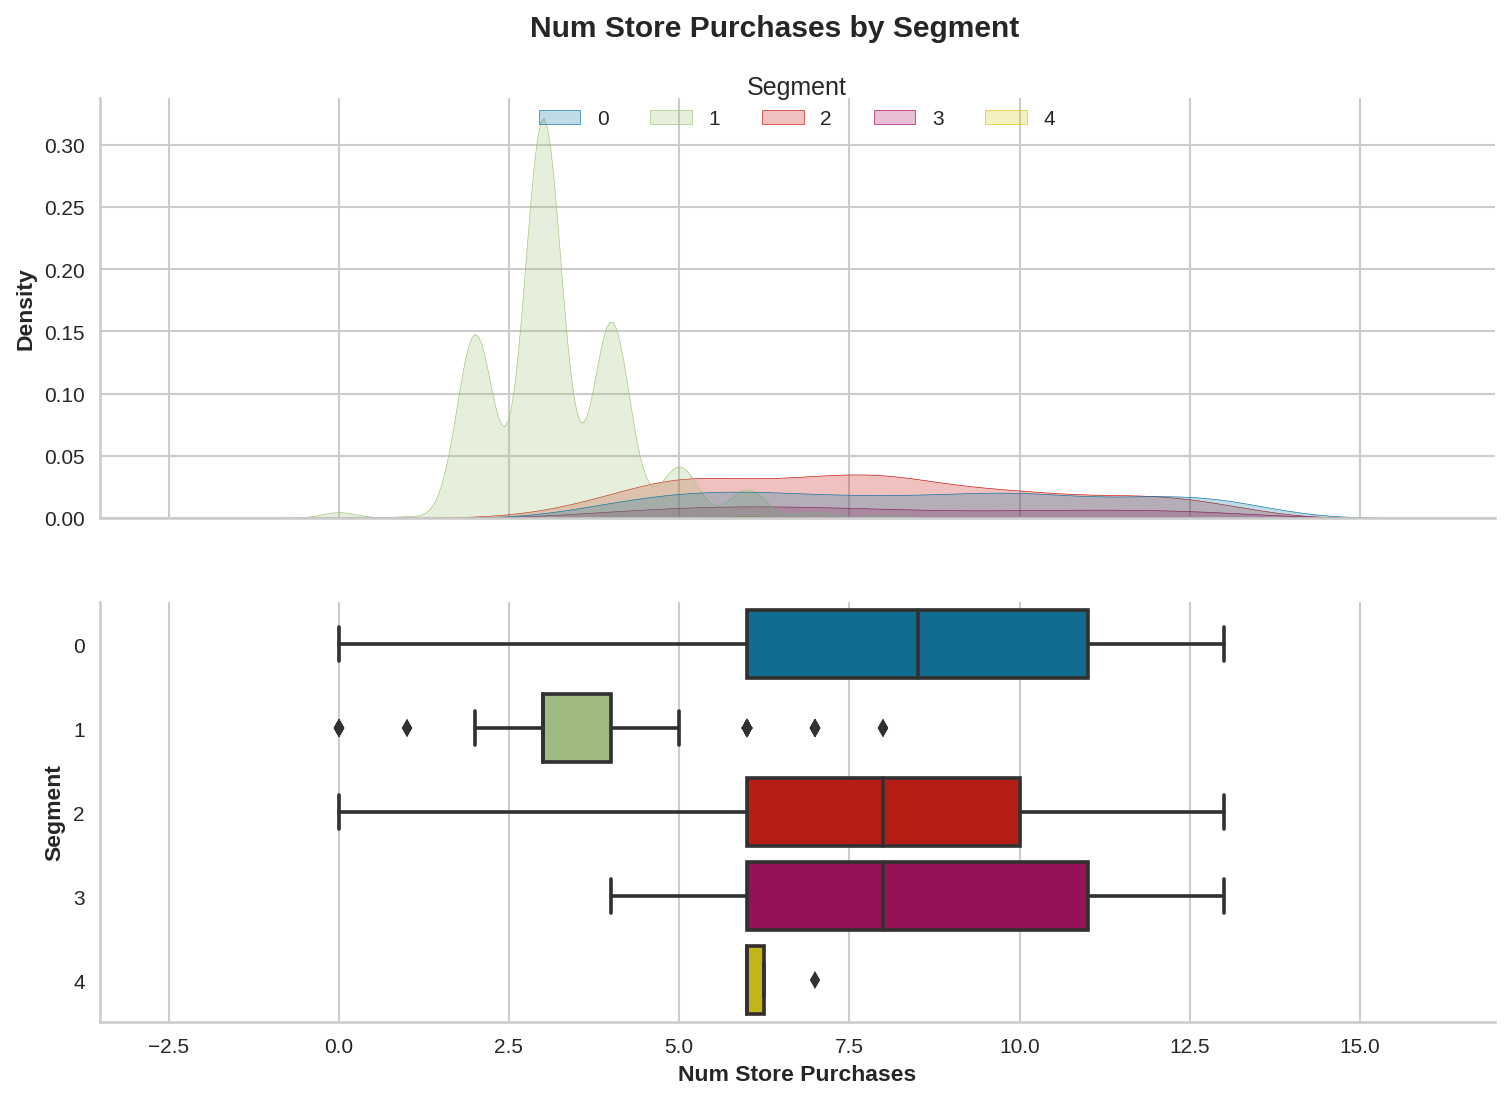

In [19]:
module.plot_kde_box(y= 'segment', x= 'num_store_purchases', df= df)

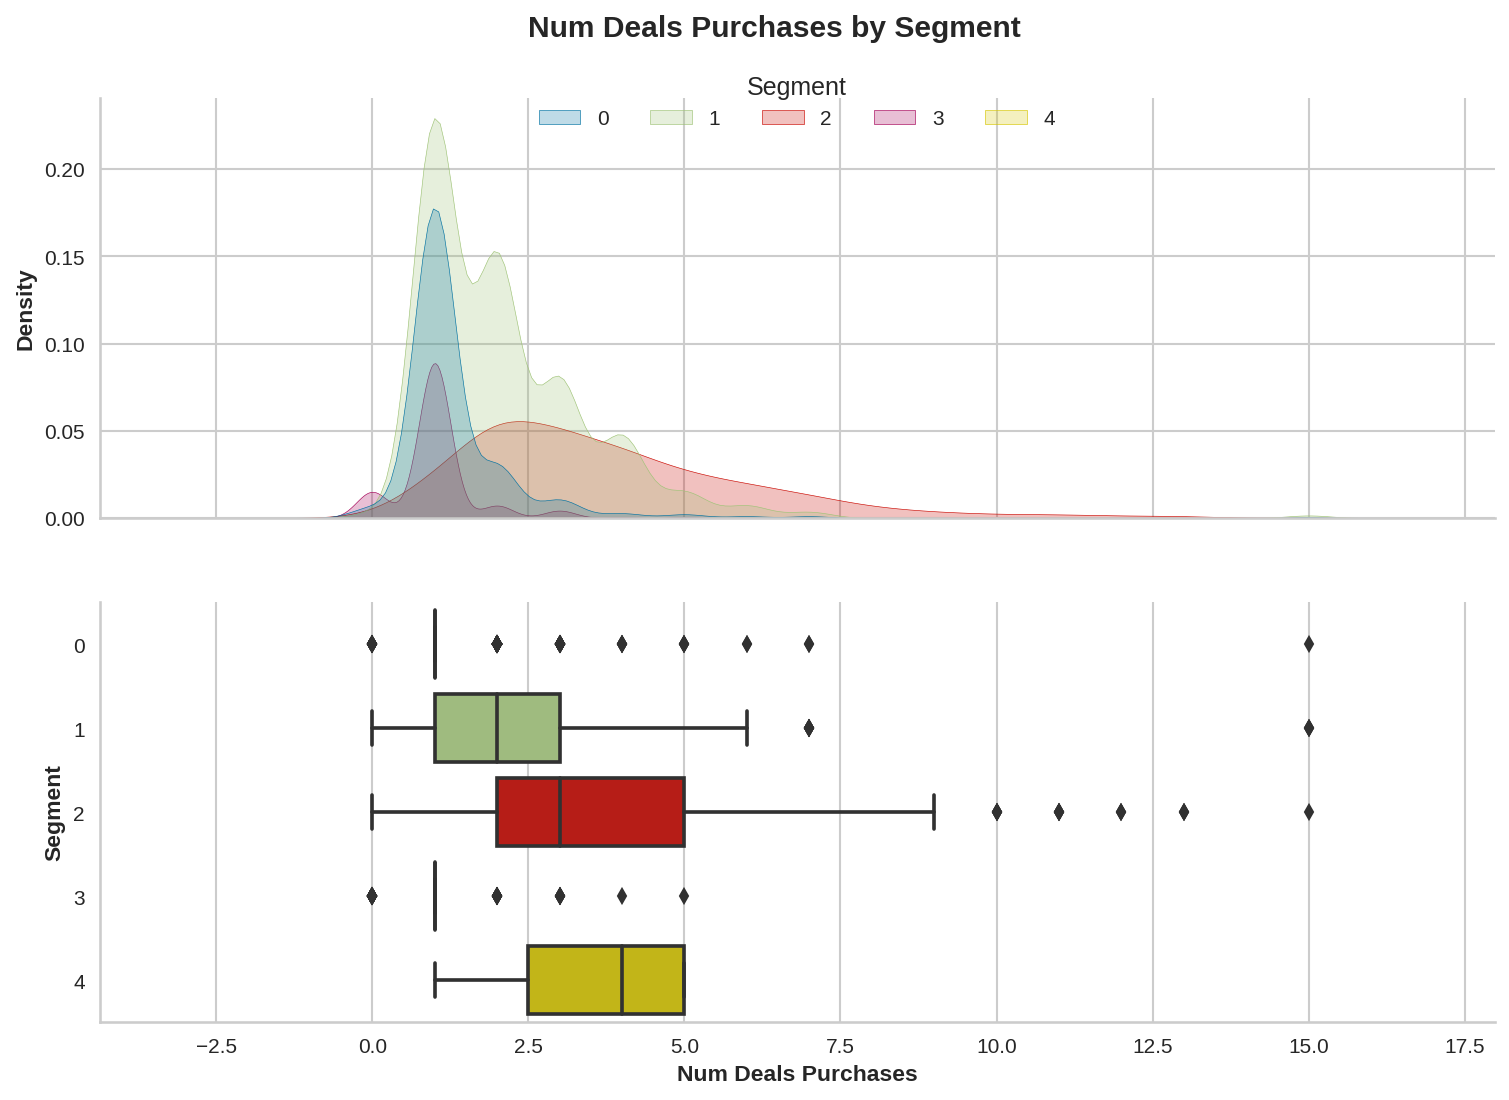

In [20]:
module.plot_kde_box(y= 'segment', x= 'num_deals_purchases', df= df)

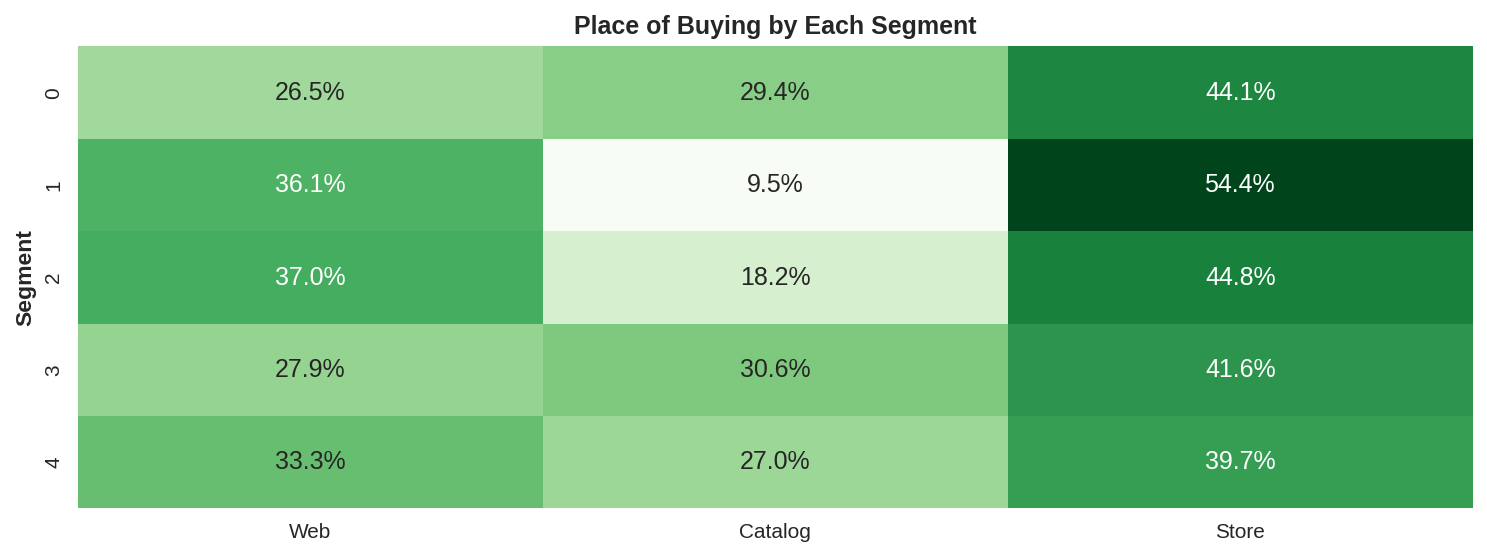

In [26]:
y= 'segment'

data= (df
    .loc[:, df.columns.str.contains('purchases|segment', regex= True)]
    .drop(columns= 'num_deals_purchases')
    .groupby(y)
    .mean()
    .apply(lambda x: (x/x.sum()), axis= 'columns')
)
module.plot_heatmap(data, 'Place of Buying by Each Segment')

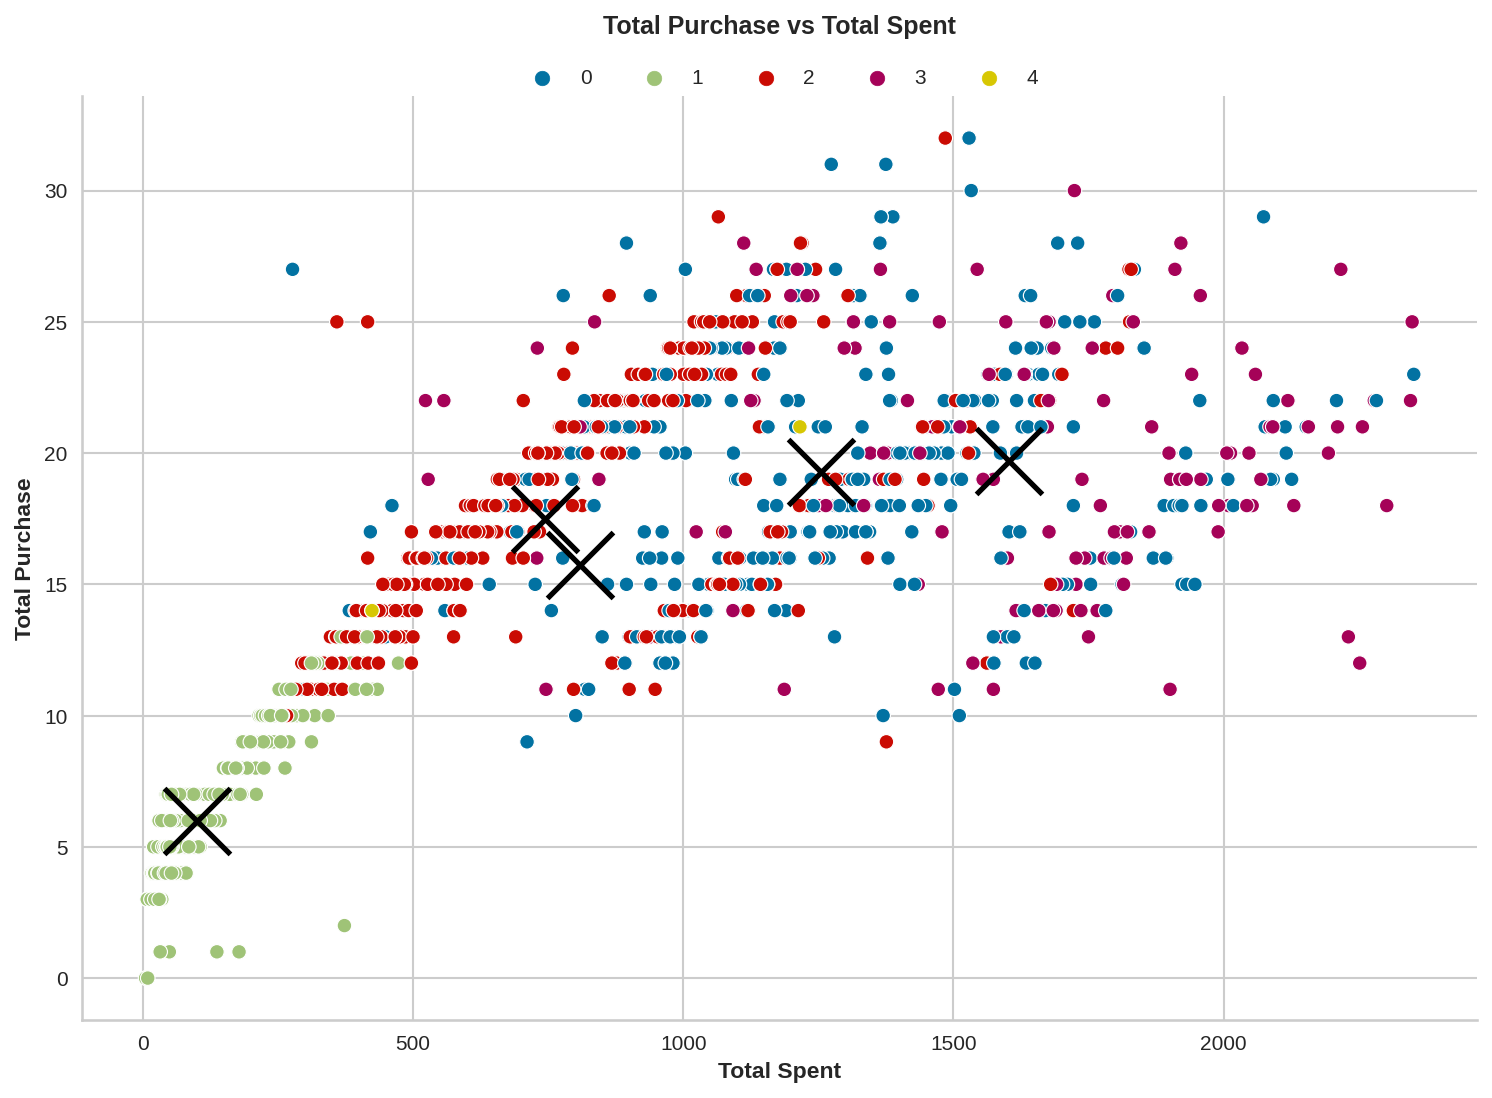

In [22]:
module.plot_scatter_with_centroids(
    x= 'total_spent',
    y= 'total_purchase',
    scaler= scaler, 
    model= kmeans, 
    df= df
)

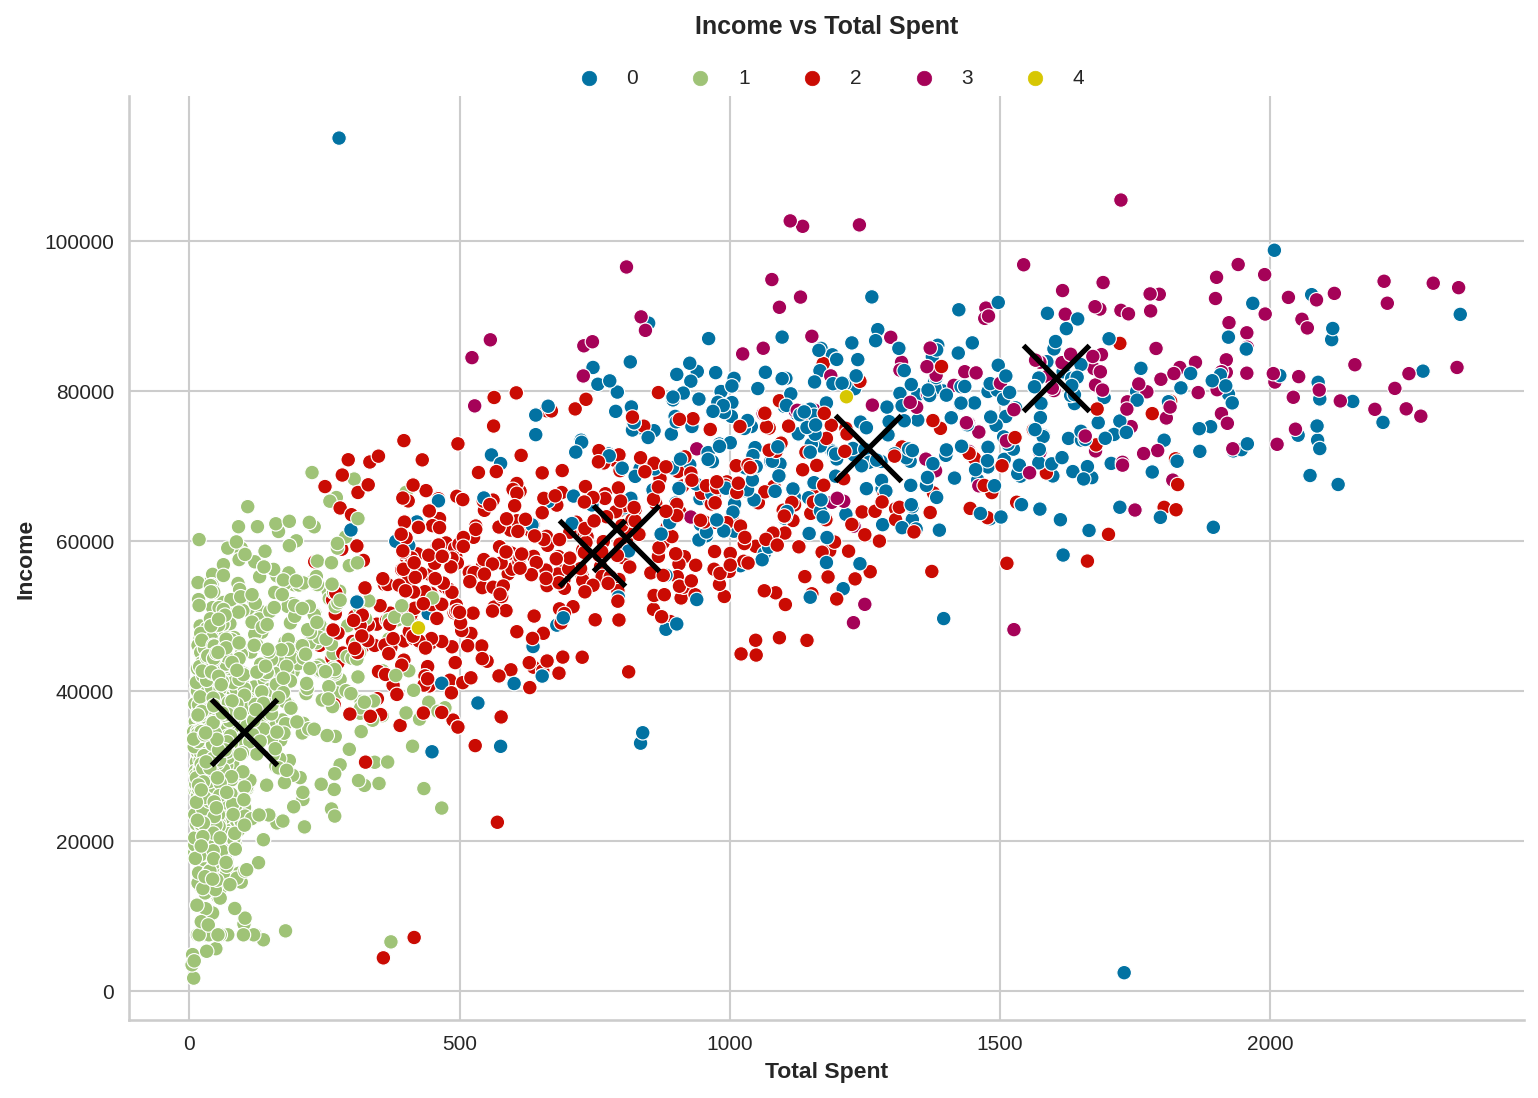

In [23]:
module.plot_scatter_with_centroids(
    x= 'total_spent',
    y= 'income',
    scaler= scaler, 
    model= kmeans, 
    df= df
)

### Segment Profile

**Segment 0:**<br>
- Young<br>
- Postgraduate<br>
- Mostly parent<br>
- Heavy on meat and gold<br>
- Visit web many times but seldom purchase<br>
- Seldom purchase via catalog<br>
- Seldom purchase in store<br>
- Often purchase with discount deals<br>
- Most often buy via web and store<br>
- Low purchase<br>
- Low spending<br>
- Low income<br>

**Segment 1:**<br>
- Young<br>
- Mostly graduate<br>
- Mostly parent<br>
- Heavy on meat and gold<br>
- Visit web many times but seldom purchase<br>
- Seldom purchase via catalog<br>
- Seldom purchase in store<br>
- Often purchase with discount deals<br>
- Most often buy via web and store<br>
- Low purchase<br>
- Low spending<br>
- Low income<br>

**Segment 2:**<br>
- Young to old<br>
- Graduate to post-graduate<br>
- Mostly not parent<br>
- Heavy on meat<br>
- Visit web few times but often purchase<br>
- Often purchase via catalog<br>
- Often purchase in store<br>
- Seldom purchase with discount deals<br>
- Most often buy via catalog and store<br>
- High purchase of expensive goods<br>
- High spending<br>
- High income<br>

**Segment 3:**<br>
- Young to old<br>
- Graduate to post-graduate<br>
- Mostly not parent<br>
- Heavy on wines and meat<br>
- Visit web few times but often purchase<br>
- Often purchase via catalog<br>
- Often purchase in store<br>
- Seldom purchase with discount deals<br>
- Most often buy via catalog and store<br>
- High purchase of expensive goods<br>
- High spending<br>
- High income<br>

**Segment 4:**
- Old<br>
- Graduate to post-graduate<br>
- Mostly parent<br>
- Heavy on wines and meat<br>
- Visit web many times and often purchase<br>
- Often purchase via catalog<br>
- Often purchase in store<br>
- Often purchase with discount deals<br>
- Most often buy via web and store<br>
- High purchase of cheap goods<br>
- Low spending<br>
- High income<br>